### Maximal Marginal Relevance Algorithm

## Introduction

Maximal Marginal Relevance Algorithm is a foundational algorithm in the field of information retrieval, first introduced in 1998 by Jamie Carboneel and Jade Goldstein in their pare *"The Use of MMR, Diversity-Based Reranking for Reordering documents and producing summaries"*
The algorithm became fundamental in modern search and recommendation systems, providing a robust method to balance relevance and diversity in ranked outputs.

## Why was it developed?
Think about it like this- you have an article written by a big tech company talking about the latest advancements in LLM and Machine Learning; and it was so popular that it was cited by 20 other articles. Now you read the article and there are a few terms in the article that you do not understand, so you go on to search about it a bit more. But as you search, based specifically on the keywords, the simplest of information retrieval algorithms may result all the 20 articles as the top matching algortihms. Well, that does not give you the results you want or more specifically the diversity you wanted. To tackle this problem, MMR was made.

## How does it work:
The MMR algorithm works by iteratively selecting documents that maximize the trade-off between relevance to the query and novelty with respect to previously selected documents. Mathematically, it can be expressed as:


The formula for MMR is:

$$
\text{MMR} = \arg\max_{D_i \in \text{Candidates}} \Big[ \lambda \cdot \text{Sim}(D_i, Q) - (1 - \lambda) \cdot \max_{D_j \in \text{Selected}} \text{Sim}(D_i, D_j) \Big]
$$

### Components:
- **$\text{Sim}(D_i, Q)$:**  
  Measures how relevant the document $D_i$ is to the query $Q$.

- **$\text{Sim}(D_i, D_j)$:**  
  Measures the similarity between document $D_i$ and document $D_j$. This helps ensure diversity by penalizing documents that are too similar to those already selected.

- **$\lambda$:**  
  A tunable parameter that determines the balance between:
  - **Relevance ($\lambda$):** Prioritizing documents that closely match the query.
  - **Diversity ($1 - \lambda$):** Avoiding redundancy by selecting diverse documents.




So basically, whatever similarity metric that you might be using, you would first calculate the similarity between the document and the query, multiply it with the factor $\lambda$ which acts like a weight to decide the important of the query's similarity with the document. We then give the remaining weight to the similarity between the previously selected document. This help manage the trade off between variance and diversity.

I implemented the MMR research algorithm based on the original paper: https://www.cs.cmu.edu/~jgc/publication/The_Use_MMR_Diversity_Based_LTMIR_1998.pdf, on a small dataset of different steel companies. You can find out the codebook [here]().

### Implementation

#### Importing Requirements

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

#### Helper Functions

In [ ]:
def analyze_column_lengths(data, column_name):
    """
    Analyzes the length of strings in a specified column of a DataFrame.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column to analyze.
    
    Prints:
    - Summary statistics of the string lengths in the column.
    - The string with the shortest length and its length.
    - The string with the longest length and its length.
    - A boxplot of the string lengths in the column.
    """
    column_lengths = data[column_name].str.len()
    length_stats = column_lengths.describe()

    print(f"Summary statistics for '{column_name}' lengths:")
    print(length_stats)
    print("\n")

    min_length_index = column_lengths.idxmin()
    max_length_index = column_lengths.idxmax()

    min_length_value = data.loc[min_length_index, column_name]
    max_length_value = data.loc[max_length_index, column_name]

    print(f"Shortest string in '{column_name}':")
    print(min_length_value)
    print(f"Length: {column_lengths[min_length_index]}")
    print("\n")

    print(f"Longest string in '{column_name}':")
    print(max_length_value)
    print(f"Length: {column_lengths[max_length_index]}")
    print("\n")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_lengths)
    plt.title(f'Boxplot of {column_name} Lengths')
    plt.xlabel(f'{column_name} Length')
    plt.show()

# Created this function to get info on the lengths of the strings

In [ ]:
def analyze_and_normalize_column(data, column_name):
    """
    Analyzes, cleans, and normalizes a specified column of a DataFrame.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column to analyze and normalize.
    
    Prints:
    - Number of unique values in original and normalized forms.
    - Lengths of unique values in both original and normalized forms.
    - Details of any inconsistent formatting.
    """
    data[column_name] = data[column_name].str.strip()
    normalized_column = data[column_name].str.lower()
    

    original_unique_values = data[column_name].unique()
    normalized_unique_values = normalized_column.unique()
    

    original_lengths = [len(value) for value in original_unique_values if pd.notna(value)]
    normalized_lengths = [len(value) for value in normalized_unique_values if pd.notna(value)]
    

    print(f"Unique values in '{column_name}' (original form):")
    print(f"Number of unique values: {len(original_unique_values)}")
    print(f"Lengths of unique values: {set(original_lengths)}")
    print(f"\nUnique values in '{column_name}' (normalized form):")
    print(f"Number of unique values: {len(normalized_unique_values)}")
    print(f"Lengths of unique values: {set(normalized_lengths)}")
    

    if len(original_unique_values) != len(normalized_unique_values):
        print("\nInconsistent formatting detected:")
        inconsistent_values = set(original_unique_values) - set(normalized_unique_values)
        print("Values with inconsistent formatting:, lowercasing to prevent irregularities")
    else:
        print("\nNo inconsistent formatting detected.")
    
    data[column_name] = normalized_column

# Created this function to get info on the unique values of the string

#### Data Preprocessing. 

I will start by looking at the data, and planning the steps of data preprocessing. Here is how I usually approach my projects:
1. Check the data types of all the columns.
2. Check for null values and handle them correctly.
3. Check for unique values or the column value distribution to manage any outliers, if needed.

In [ ]:
companies = pd.read_csv('./companies.csv')
companies.head()


,Name,EmployeeCount,Description,Url,Region,Country,MetroArea,City
0,Molan Steel Co.,11-50,Molan Steel Co. engages in supplying steel pro...,molansteel.com,RY,SA,Riyadh/Saudi Arabia Metro,Riyadh
1,Hunter Douglas NV,10001+,"Hunter Douglas NV engages in the design, manuf...",hunterdouglas.com,ZH,NL,Amsterdam/NL Metro,Rotterdam
2,"Root, Inc.",501-1000,"Root, Inc. is a technology insurance company, ...",inc.joinroot.com,OH,US,Columbus/OH Metro,Columbus
3,Bowlero Corp.,10001+,Bowlero Corp. engages in operating bowling cen...,bowlero.com,VA,US,Richmond/VA Metro,Mechanicsville
4,Meridia Real Estate III SOCIMI SA,1-10,Meridia Real Estate III SOCIMI SA operates as ...,meridiarealestateiiisocimi.com,CT,ES,Barcelona/Spain Metro,Barcelona


##### Checking the data types of each column

In [ ]:
print(companies.dtypes) # Checking the data types

Name             object
EmployeeCount    object
Description      object
Url              object
Region           object
Country          object
MetroArea        object
City             object
dtype: object


One thing that strikes out to me is that instead of having strings of employee count, I could have numerical values. But then we do not need numerical data here.

##### Checking for null values

In [ ]:
# Checking for null values
companies.isnull().sum()

Name               0
EmployeeCount      0
Description       61
Url              552
Region            51
Country            2
MetroArea          0
City               0
dtype: int64

Information wise, Description is one of the most important columns. 
- The URL column, might not be as useful, so I can go ahead and remove it. The words in URL maybe be removed after preprocessing or they do not give out any useful information, as they do not pertain to any specific root and maybe used as stopwords.
- I would not be using the Employee Count column as well. So it is safe to remove that.
-  For the description column, I do not want to lose the information about these 61 entries, so I would just replace the null values with a small word such as NA. I could use a big word such as No additional description, but it may interfere with the corpus as a whole in the vectorization process.
- For Region and country, I followed the same logic and replaced it by Unknown.


In [ ]:
# Replacing the null values of description with NA avaiable.
companies['Description'].fillna('NA', inplace = True)
# Removing the column URL
companies = companies.drop(columns = ['Url'])
# Replacing Region with NA
companies['Region'].fillna('Unknown', inplace = True)
# Replacing country with NA
companies['Country'].fillna('Unknown',inplace=True)

##### Checking the unique value in each of the columns.
- For name there should be all the unqiue values, so we should rather check for duplicates there or any empty string.
- For the description column, check the length distribution of the strings in it.
- For the url column, maybe check the average length distribution of the strings in it.
- For the region column, check the unique values.
- For the country column, check the unique values
- For the metroarea also check the unique values
- For the city also check the unique values.

In [ ]:
# Checking duplicates in name:
print(companies[companies['Name'].duplicated()])
# No duplicates found

Empty DataFrame
Columns: [Name, EmployeeCount, Description, Region, Country, MetroArea, City]
Index: []


Here, I used one of my helper functions to get information on the lengths of specific columns. This way I am able to interpret any mistakenly entered information or data, that might not be useful for us such. Example, maybe the description was entered just as a single word. I use this on different columns

Summary statistics for 'Description' lengths:
count    17389.000000
mean       465.478866
std        254.049949
min          2.000000
25%        291.000000
50%        390.000000
75%        578.000000
max       2221.000000
Name: Description, dtype: float64


Shortest string in 'Description':
NA
Length: 2


Longest string in 'Description':
Dover Corp. operates as a manufacturer and solutions provider delivering innovative equipment and components, consumable supplies, aftermarket parts, software and digital solutions, and support services. It operates through the following segments: Engineered Products, Clean Energy and Fueling, Imaging and Identification, Pumps and Process Solutions, and Climate and Sustainability Technologies. The Engineered Products segment is involved in the equipment, components, software, solutions and services to the vehicle aftermarket, waste handling, industrial automation, aerospace and defense, industrial winch and hoist, and fluid dispensing end-markets. The 

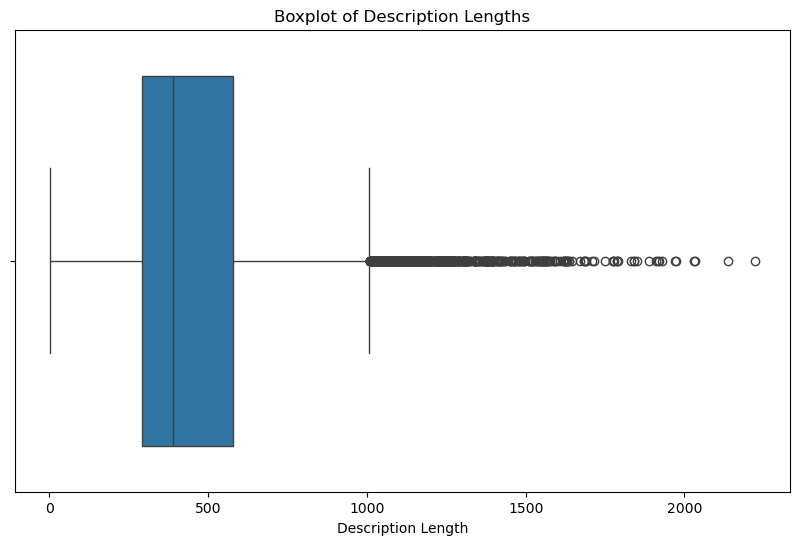

In [ ]:
analyze_column_lengths(companies, 'Description')

This makes sure that we do not have a description that suggests nothing but blank spaces or irrelevant information.

Here, I used another one of my helper functions, whose goal was to check for consistent formatting. If it does detect it it just converts the whole column to lowercase to remove ambiguity. The main aim was to check for values such as United States and united states and make sure that they are represented by a one reference rather than two. 

In [ ]:
analyze_and_normalize_column(companies, 'Region')

Unique values in 'Region' (original form):
Number of unique values: 373
Lengths of unique values: {2, 7}

Unique values in 'Region' (normalized form):
Number of unique values: 373
Lengths of unique values: {2, 7}

No inconsistent formatting detected.


In [ ]:
analyze_and_normalize_column(companies, 'Country')

Unique values in 'Country' (original form):
Number of unique values: 113
Lengths of unique values: {2, 7}

Unique values in 'Country' (normalized form):
Number of unique values: 113
Lengths of unique values: {2, 7}

No inconsistent formatting detected.


In [ ]:
analyze_and_normalize_column(companies, 'MetroArea')

Unique values in 'MetroArea' (original form):
Number of unique values: 143
Lengths of unique values: {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}

Unique values in 'MetroArea' (normalized form):
Number of unique values: 143
Lengths of unique values: {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}

No inconsistent formatting detected.


In [ ]:
analyze_and_normalize_column(companies, 'City')

Unique values in 'City' (original form):
Number of unique values: 3927
Lengths of unique values: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29}

Unique values in 'City' (normalized form):
Number of unique values: 3920
Lengths of unique values: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29}

Inconsistent formatting detected:
Values with inconsistent formatting:, lowercasing to prevent irregularities


In [ ]:
companies.head()

,Name,EmployeeCount,Description,Region,Country,MetroArea,City
0,Molan Steel Co.,11-50,Molan Steel Co. engages in supplying steel pro...,ry,sa,riyadh/saudi arabia metro,riyadh
1,Hunter Douglas NV,10001+,"Hunter Douglas NV engages in the design, manuf...",zh,nl,amsterdam/nl metro,rotterdam
2,"Root, Inc.",501-1000,"Root, Inc. is a technology insurance company, ...",oh,us,columbus/oh metro,columbus
3,Bowlero Corp.,10001+,Bowlero Corp. engages in operating bowling cen...,va,us,richmond/va metro,mechanicsville
4,Meridia Real Estate III SOCIMI SA,1-10,Meridia Real Estate III SOCIMI SA operates as ...,ct,es,barcelona/spain metro,barcelona


Removing the employee count column as we do not really need those numbers.

In [ ]:
companies = companies.drop(columns=['EmployeeCount'])

The data is now cleaned, and ready to be used. Taking a last look at the data

In [ ]:
companies.head()

,Name,Description,Region,Country,MetroArea,City
0,Molan Steel Co.,Molan Steel Co. engages in supplying steel pro...,ry,sa,riyadh/saudi arabia metro,riyadh
1,Hunter Douglas NV,"Hunter Douglas NV engages in the design, manuf...",zh,nl,amsterdam/nl metro,rotterdam
2,"Root, Inc.","Root, Inc. is a technology insurance company, ...",oh,us,columbus/oh metro,columbus
3,Bowlero Corp.,Bowlero Corp. engages in operating bowling cen...,va,us,richmond/va metro,mechanicsville
4,Meridia Real Estate III SOCIMI SA,Meridia Real Estate III SOCIMI SA operates as ...,ct,es,barcelona/spain metro,barcelona


In [ ]:
companies.isnull().sum()

Name           0
Description    0
Region         0
Country        0
MetroArea      0
City           0
dtype: int64

Creating a combined text column so that we all have all the necessary information under one column, and it is then easy to vectorize.

In [ ]:
companies['combined_text'] = companies['Description'] + " " +companies['Region'] + " " + companies['Country'] + " " + companies['MetroArea'] + " " + companies['City']

#### Search Algoritm -  Basic

For the basic search algorithm, I am using the TF IDF vectorization, and then calculating the cosine similarity. I will explain more about this approach in the answer box below.

In [ ]:
def search(query: str, companies: pd.DataFrame, n=100) -> pd.DataFrame:
    """
    Searches for the most relevant companies based on a query using TF-IDF vectorization and cosine similarity.

    Parameters:
    - query (str): The search query to find relevant companies.
    - companies (pd.DataFrame): A DataFrame containing company data with a 'combined_text' column for text search.
    - n (int): The number of top results to return (default is 100).

    Returns:
    - pd.DataFrame: A DataFrame containing the top-n most relevant companies and their similarity scores.
    """

    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(companies['combined_text'])
    query_vec = tfidf.transform([query])

    cosine_similarities = linear_kernel(query_vec, tfidf_matrix).flatten()

    top_n_indices = cosine_similarities.argsort()[-n:][::-1]

    results = companies.iloc[top_n_indices].copy()
    results['similarity_score'] = cosine_similarities[top_n_indices]
    
    return results

#### Search Algorithm MMR

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import linear_kernel

def rerank(results: pd.DataFrame, lambda_param: float = 0.5, n=10) -> pd.DataFrame:
    """
    Re-ranks the search results based on Maximal Marginal Relevance (MMR) to balance relevance and diversity.

    Parameters:
    - results (pd.DataFrame): DataFrame containing the search results with 'combined_text' and similarity scores.
    - lambda_param (float): Trade-off parameter between relevance and redundancy (default is 0.5).

    Returns:
    - pd.DataFrame: A DataFrame with the results re-ranked based on MMR and including the MMR score.
    """
    if results.empty:
        return results
    
    # Ensure 'vector' column exists
    if 'vector' not in results.columns:
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(results['combined_text'])
        results['vector'] = [tfidf_matrix.getrow(i).toarray()[0] for i in range(tfidf_matrix.shape[0])]
    else:
        vectors = np.array(results['vector'].tolist())
    
    vectors = np.array(results['vector'].tolist())
    relevance_scores = results['similarity_score'].values

    # Compute pairwise cosine similarities (redundancy)
    redundancy_matrix = linear_kernel(vectors, vectors)
    np.fill_diagonal(redundancy_matrix, 0)  # No self-similarity
    max_redundancy = redundancy_matrix.max(axis=1)

    # Compute MMR scores
    mmr_scores = lambda_param * relevance_scores - (1 - lambda_param) * max_redundancy

    # Add MMR scores to results and sort by MMR score
    results['mmr_score'] = mmr_scores
    ranked_results = results.sort_values(by='mmr_score', ascending=False).head(n)

    return ranked_results.drop(columns=['vector'])


### Demo

In [ ]:
query = "steel manufacturing company"
results = search(query, companies, n=10)

print("Top 5 Search Results:")
results[['Name', 'similarity_score', 'Description','Region','Country','MetroArea','City']]

Top 5 Search Results:


,Name,similarity_score,Description,Region,Country,MetroArea,City
17327,"Yamato Kogyo Co., Ltd.",0.633366,"Yamato Kogyo Co., Ltd. engages in the manageme...",hy,jp,osaka/japan metro,himeji
9911,Argent Industrial Ltd.,0.619324,Argent Industrial Ltd. operates as a holding c...,nl,za,johannesburg/s.afr. metro,durban
15209,AnnAik Ltd.,0.512000,"AnnAik Ltd. is an investment holding company, ...",ce,sg,singapore metro,singapore
15230,Kori Holdings Ltd.,0.502256,"Kori Holdings Ltd. is an investment company, w...",ce,sg,singapore metro,singapore
10589,"Steel Dynamics, Inc.",0.497093,"Steel Dynamics, Inc. engages in the manufactur...",in,us,indianapolis/in metro,fort wayne
17124,Kyoei Steel Ltd.,0.481389,"Kyoei Steel Ltd. engages in the manufacture, s...",os,jp,osaka/japan metro,osaka
11913,Swiss Steel Holding AG,0.475330,Swiss Steel Holding AG engages in the producti...,lu,ch,zurich/switzerland metro,lucerne
1188,Al Yamamah Steel Industries Co.,0.473252,Al Yamamah Steel Industries Co. engages in the...,ry,sa,riyadh/saudi arabia metro,riyadh
14855,EVRAZ Plc,0.460026,"EVRAZ Plc is a holding company, which engages ...",gl,gb,london/uk metro,london
15453,Lion Asiapac Ltd.,0.452858,Lion Asiapac Ltd. operates as an investment ho...,ce,sg,singapore metro,singapore


In [ ]:
rerank(search('companies who manufacture steel products', companies), n=5)

,Name,Description,Region,Country,MetroArea,City,combined_text,similarity_score,mmr_score
17327,"Yamato Kogyo Co., Ltd.","Yamato Kogyo Co., Ltd. engages in the manageme...",hy,jp,osaka/japan metro,himeji,"Yamato Kogyo Co., Ltd. engages in the manageme...",0.580026,0.174434
9191,Ternium Argentina SA,Ternium Argentina SA engages in the manufactur...,ba,ar,buenos aires/argentina,buenos aires,Ternium Argentina SA engages in the manufactur...,0.359326,0.132524
9911,Argent Industrial Ltd.,Argent Industrial Ltd. operates as a holding c...,nl,za,johannesburg/s.afr. metro,durban,Argent Industrial Ltd. operates as a holding c...,0.500829,0.125165
10589,"Steel Dynamics, Inc.","Steel Dynamics, Inc. engages in the manufactur...",in,us,indianapolis/in metro,fort wayne,"Steel Dynamics, Inc. engages in the manufactur...",0.465828,0.119376
14855,EVRAZ Plc,"EVRAZ Plc is a holding company, which engages ...",gl,gb,london/uk metro,london,"EVRAZ Plc is a holding company, which engages ...",0.427854,0.118635


For the base search I used the Tf-idf vectorization on the texts, to convert them into numbers, and then calculate the cosine similarity between the vectors. Here is a quick rundown on how the TF- IDF vectorization converts text into numbers.

$$
\text{TF}(t, d) = \frac{\text{Number of times } t \text{ appears in } d}{\text{Total number of terms in } d}
$$


$$
\text{IDF}(t) = \log \left(\frac{N}{1 + \text{Number of documents containing } t}\right)
$$


$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$


The principles of MMR continue to resonate in contemporary systems:

**Diversity in Search Results**:
Modern search systems rely on MMR-inspired techniques to ensure diverse viewpoints, especially in subjective or controversial topics like news or opinions.

**AI-Powered Summarization**:
Tools like SummarizeBot or features in Google Docs use extractive summarization that incorporates MMR to provide coherent and non-redundant summaries.




**Conclusion:**
Overall, MMR built a strong foundation for a lot of search and systems that came after it - recommendation systems, summarization systems and a plethora of systems that we use today. As we reach a rapid developing age of Artifical Intelligence, and prompt generated videos, we all have Carbonell and Goldstein to thank for it all. They built the foundation that helped push the wheel of AI. 

I hope this post was informative, reach out to me for any further questions.